## The problem with perfect phylogenies

Previously, I wrote [a blog post](https://genomejigsaw.wordpress.com/2015/09/09/building-phylogenetic-trees-with-binary-traits/), exploring the _Gusfield algorithm_ for building phylogenetic trees from binary traits. While the algorithm works well if you have a clean matrix that just-so happes to form a perfect phylogeny, if you experiment with different matrix permutations of 1s and 0s, you'll quickly find that matrices which create perfect phylogenies are scarce. Indeed, if there are any pairs of columns $[C1,C2]$ that have the values $[0,1]$, $[1,0]$ and $[1,1]$, then a perfect phylogeny cannot be built. Imperfect data sources and noisy data can contribute to the difficulties of building a valid phylogeny. To allow for some slack for running the phylogeny-finding algorithm, one option is to use the _imperfect phylogeny algorithm_, which is described (and implemented in near-linear time) in a [paper by Pe'er et al.](http://epubs.siam.org/doi/abs/10.1137/S0097539702406510) (pay-walled, unfortunately). I will explain and implement this algorithm in code in this post. If you're after the mathematical proofs or description, refer to the original paper, or this, more digestable, [review](http://carolineuhler.com/paperCS.pdf).

## A motivation for using the imperfect phylogeny algorithm

In modelling phylogenetic trees from binary data, it is unlikely that you'll have absolute certainty in observing data values. In my early experiments of my PhD project, I was utilising the Gusfield algorithm for [structural variation](http://www.ncbi.nlm.nih.gov/dbvar/content/overview/) (SV) data in multiple tumour biopsies from the same patient. In my case, observing the same structural variation across several tumour samples of the same patient gave me high confidence that the variation existed. However, I was much less confident when I did _not_ see variant in one patient sample, when it was clearly present in others. Thus, my '1's were certain, but my '0's were uncertain. In the case of structural variants, there are several reasons why we might not detect a variant in a particular sample (the [depth of coverage](https://en.wikipedia.org/wiki/Deep_sequencing) may be too low, or the sample may have a low amount of tumour content). In this case, when I constructed my matrix of shared SV events, I would mark the rows of my low-quality samples with 'incomplete' (unknown) values to represent this uncertainty. This strategy allowed me to find valid phylogenies where previously they could not be found.

## The incomplete phylogeny problem

In our feature matrix, we now allow a third feature type - unknown or incomplete, denoted by '?'. Hence our values can be 0, 1 or ? for any cell. The incomplete phylogeny algorithm will then infer the unknown values by determining whether the sample belongs to the 'clade' associated with the feature - the clade being the evolutionary group with a common ancestor, that the sample/species evolved from. 

The algorithm will output a perfect phylogeny tree $T$ (if present), as well as the corresponding completed matrix $M$. The algorithm is composed of the following steps:

1. Remove any columns in our matrix $M$ with no 0s or all 0s.
2. Construct a graph where 1s represent edges between features (columns) and samples (rows).
3. Get each set of connections where there are >1 connections (call these _K_) in the graph $G$, for each _K_ (while $G \neq \emptyset$):

    i. get all the samples ($S$ or rows) in $K$, call this $S'$.
    
    ii. for this set of $S'$, get all the features ($C$ or columns) where there are no 0 entries, call this $U$.
    
    iii. if there are no elements in $U$, stop.
    
    iv. otherwise remove $U$ from the graph $G$ (also removing any connections), and add $S'$ to our tree $T$.
       
4. For any $C$s that are _associated_ with the clade $S$ (a group is $S$s), set these to 1, otherwise 0.
5. Return $T$ and $M'$.

The vector $T$ now represents our phylogenetic tree. This represents the clades that are present in our tree. For instance, if $T = \{\{s1,s2,s3,s4\},\{s1,s2\},\{s3,s4\}\}$, this means that our 'super-clade' has 4 elements, $\{s1,s2,s3,s4\}$, and two clades consisting of $\{s1,s2\}$ and $\{s3,s4\}$, which are more related than the other pairs. The tree could be drawn as:

                                                        /\
                                                       /  \
                                                      /    \
                                                     /\    /\
                                                    /  \  /  \
                                                   s2 s2  s3 s4

To implement the algorithm, Let's work from the following matrix (already sorted by its binary values, see [previous post](https://genomejigsaw.wordpress.com/2015/09/09/building-phylogenetic-trees-with-binary-traits/) for more info):

|    | C1 | C2 | C3 | C4 | C5 |
|----|----|----|----|----|----|
| S1 | 1  | 1  | 0  | 0  | ?  |
| S2 | 0  | ?  | 1  | 0  | ?  |
| S3 | 1  | ?  | 0  | 0  | 1  |
| S4 | 0  | 0  | 1  | 1  | ?  |
| S5 | 0  | 1  | 0  | 0  | ?  |


We will now transform this matrix into a graph, creating connections between the nodes, $C$s and $S$s. Edges are defined where $C$ and $S$ share a value of '1'. To do this, we first code up an graph implementation, with nodes and edges. One approach can be found [here](http://interactivepython.org/runestone/static/cs22-lbcc/Graphs/graphintro.html) - the base graph code, as well as the $M$ Graph implementation are in the mgraph.py file in this repository.

In [12]:
from mgraph import MGraph

We now build our arrays for our $S$s and $C$s, as well as or _M_ matrix. Let's use -1 to represent the 'incomplete' state of our matrix. 

In [13]:
from mgraph import MGraph
import numpy as np

s = np.array(['s1','s2','s3','s4','s5'])
c = np.array(['c1','c2','c3','c4','c5'])
m = np.array([[ 1,  1,  0,  0, -1],
              [ 0, -1,  1,  0, -1],
              [ 1, -1,  0,  0,  1],
              [ 0,  0,  1,  1, -1],
              [ 0,  1,  0,  0, -1]])

# create working matrix M and column C vector copies
m3 = m.copy()
c3 = c.copy()

# remove any columns where there are no 0 entries
mi = np.empty(0,dtype='int')
ncol = len(m3[0])
idxs_to_delete = [i for i in range(ncol) if not np.any(m3[:,i:i+1]==0)]
m3 = np.delete(m3,idxs_to_delete,axis=1)
c3 = np.delete(c3,idxs_to_delete)

m_graph = MGraph()
m_graph.build_graph(m3,s,c3)
m_pairs = m_graph.get_edge_pairs()

print('Nodes in our graph')
print(m_graph.getNodes())

print('\nPairwise connections between out nodes')
print(m_graph.get_edge_pairs())

Nodes in our graph
['s3', 's2', 's1', 's5', 's4', 'c3', 'c2', 'c1', 'c4']

Pairwise connections between out nodes
[['s3', 'c1'], ['s2', 'c3'], ['s1', 'c1'], ['s1', 'c2'], ['s5', 'c2'], ['s4', 'c3'], ['s4', 'c4']]


The variable m_pairs (above) displays the graph connections between our $S$s and $C$s. We now get the first set of connections in the graph, and determine the $K$ vector (which is the union of all $S$s and $C$s involved in the graph connection). Below is a drawing of the graph connections between the $S$ and $C$ nodes. I have colour-coded the connections corresponding to contigous sets of connections - these will correspond to the clades, as we will discover through the algorithm.

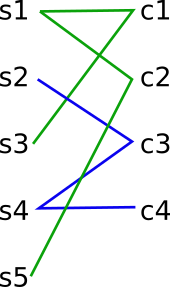

In [22]:
from IPython.display import Image
Image(filename='m3_graph.png')

To illustrate the algorithm step by step, we will do one full iteration of step 3.

In [14]:
def get_k(k,q,m_graph):
    '''
    return the first K vector with E[K] >= 1
    (the K vector contains all elements of a chain of connected 
    vertices with more than just one connection between them)
    '''
    if not q:
        return k
    else:
        q1 = q.pop()
        k.add(q1) 
        pairs = m_graph.get_pairs_containing(q1)
        pairs = set([node for pair in pairs for node in pair]) #flatten set of elements
        for node in pairs:
            if node not in k:
                q.add(node)
        return get_k(k,q,m_graph)

q = set(m_pairs[0]) #pick the first elements as k
print(q)
k = get_k(set(),q,m_graph)
print(k)

set(['s3', 'c1'])
set(['s3', 'c2', 'c1', 's1', 's5'])


Based on the $S$s returned in the connections ($K \cup S'$), we now return the slice of the $M_3$ array, on the rows in $S'$.

In [15]:
s_prime = set(s).intersection(k)
s_indexes = np.array([np.where(s_i==s)[0][0] for s_i in s_prime])
m_tmp = m3.copy()[s_indexes]
m_tmp

array([[ 1, -1,  0,  0],
       [ 1,  1,  0,  0],
       [ 0,  1,  0,  0]])

Now we return our $U$ vector, which is defined as any $C$s where there are no $0$s (of the above slice). 

In [16]:
u = []
c_in_k = set(c).intersection(k)
for c_i in c_in_k:
    c_index = np.where(c_i==c3)[0]
    m_col = m_tmp[:,c_index:c_index+1]
    if np.all(m_col!=0):
        cm = np.where(c_i==c3)[0]
        u.append(c_i)
print(u)

['c2']


Now any elements that are in the character columns contained in $U$, *and* in the sample rows contained in $S'$ (i.e. they belong to the same clade), will have any incomplete fields inferred as present. (This is skipping ahead to step 4, but this is just to demonstrate.)

In [17]:
m_new = m3.copy()

c_indexes = [np.where(c3==x)[0][0] for x in u]
for c_idx in c_indexes:
    m_col = m_new[s_indexes,c_idx:c_idx+1]
    if np.any(m_col==-1):
        m_col[m_col==-1] = 1
        m_new[s_indexes,c_idx:c_idx+1] = m_col
        
print("Incomplete matrix prior to algorithm step")
print(m3)
print("\nMatrix after first round of algorithm")
print(m_new)

Incomplete matrix prior to algorithm step
[[ 1  1  0  0]
 [ 0 -1  1  0]
 [ 1 -1  0  0]
 [ 0  0  1  1]
 [ 0  1  0  0]]

Matrix after first round of algorithm
[[ 1  1  0  0]
 [ 0 -1  1  0]
 [ 1  1  0  0]
 [ 0  0  1  1]
 [ 0  1  0  0]]


Hence in the above example, the matrix $M_3$ cell corresponding to $S3$ and $C2$ has been inferred to be present (i.e. 1). 

Finally we can put the whole algorithm together. This example follows the example from [this paper](http://carolineuhler.com/paperCS.pdf), which also provides an illustration of the node connections in the "$\sum$-free graph". 

In [18]:
m_graph = MGraph()
m_graph.build_graph(m3,s,c3)
m_pairs = m_graph.get_edge_pairs()

q = set(m_pairs[0]) #pick the first elements as k
k = get_k(set(),q,m_graph)
t = [set(s)] #initialise a tree

while len(m_pairs) > 1:
    while len(k) < 3: #
        for n in k:
            m_graph.delNode(n)
        m_pairs = m_graph.get_edge_pairs()
        if len(m_pairs) > 1:
            q = set(m_pairs[0]) 
            k = get_k(set(),q,m_graph)
        else: 
            break
    
    s_prime   = set(s).intersection(k)                
    s_indexes = np.array([np.where(s_i==s)[0][0] for s_i in s_prime])
    m_tmp     = m3.copy()[s_indexes]

    print('k:')
    print(k)
    print("S':")
    print(s_prime)
    
    u = []
    c_in_k  = set(c).intersection(k)
    for c_i in c_in_k:
        c_index = np.where(c_i==c3)[0]
        m_col = m_tmp[:,c_index:c_index+1]
        if np.all(m_col!=0):
            cm = np.where(c_i==c3)[0]
            u.append(c_i)
    
    if not u:
        break
    else:
        print('u:')
        print(u)
        t.append(s_prime)
        for n in u:
            m_graph.delNode(n)
        m_pairs = m_graph.get_edge_pairs()
        k = get_k(set(),set(m_pairs[0]),m_graph)
        print('Tree:')
        print(t)

k:
set(['s3', 'c2', 'c1', 's1', 's5'])
S':
set(['s3', 's1', 's5'])
u:
['c2']
Tree:
[set(['s3', 's2', 's1', 's5', 's4']), set(['s3', 's1', 's5'])]
k:
set(['s3', 'c1', 's1'])
S':
set(['s3', 's1'])
u:
['c1']
Tree:
[set(['s3', 's2', 's1', 's5', 's4']), set(['s3', 's1', 's5']), set(['s3', 's1'])]
k:
set(['c3', 's2', 'c4', 's4'])
S':
set(['s2', 's4'])
u:
['c3']
Tree:
[set(['s3', 's2', 's1', 's5', 's4']), set(['s3', 's1', 's5']), set(['s3', 's1']), set(['s2', 's4'])]


Hence our final tree looks like:

                                                        /\
                                                       /  \ 
                                                      /   /\
                                                     /  s5  \                                                     
                                                    /\      /\
                                                  s2  s4   s3 s1
